In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
np.array([1,2])-1

array([0, 1])

In [15]:
from utilities.userfold_framework import *
# from utilities.EEG_func import *
import Models.model_func as Model_Func
from Models.AR_EEG_models import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn


DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]
for r in [0]:
    participants_dictionary=[]
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        classifier= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)


    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))


        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
        model= LSTM_EEGNet_Wrapper(DEVICE, classifier, input_dim).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

#         if i in np.array([16])-1:
        
#         train_func= eeg_train
#         model.training_procedure(iteration=n_epochs,
#                                         train_dataloader=train_dataloader,
#                                          val_dataloader=val_dataloader,
#                                          print_cycle=2,
#                                          path=f"./dictionary/intermdiate_dicts",
#                                          loss_func=criterion,
#                                          optimiser=optimizer, #scheduler=scheduler,
#                                          train_func=train_func
#                                         )
#         if model.epoch == n_epochs+1:
#             EPOCH= n_epochs
#         else:
#             EPOCH= model.epoch

#         torch.save(model.state_dict(), 
#                os.path.join(
#                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Baseline-e{EPOCH}.pt"
#                )
#         )
#         else:
    # OR
        model.load_state_dict(
        torch.load(
            open(
                os.path.join(
                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Baseline-e{n_epochs}.pt"
                ), "rb"
            )
                  )
        )


        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
        participants_dictionary.append(dictionary)
        
#     pickle.dump(participants_dictionary, open(f"{saved_dir}/participant_dictionary-LSTM_EEGNet.pkl","wb"))
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


108 16

c0_acc 0.972972972972973 , c1_acc 0.32 , b_acc 0.6464864864864865
111 11

c0_acc 0.9652173913043478 , c1_acc 0.20754716981132076 , b_acc 0.5863822805578343
110 13

c0_acc 0.8943089430894309 , c1_acc 0.24528301886792453 , b_acc 0.5697959809786777
125 11

c0_acc 0.9541984732824428 , c1_acc 0.19642857142857142 , b_acc 0.5753135223555071
111 7

c0_acc 0.9487179487179487 , c1_acc 0.14285714285714285 , b_acc 0.5457875457875457
116 6

c0_acc 0.928 , c1_acc 0.12 , b_acc 0.524
109 19

c0_acc 0.872 , c1_acc 0.3392857142857143 , b_acc 0.6056428571428571
121 8

c0_acc 0.9603174603174603 , c1_acc 0.13559322033898305 , b_acc 0.5479553403282217
126 18

c0_acc 0.9473684210526315 , c1_acc 0.32727272727272727 , b_acc 0.6373205741626794
125 18

c0_acc 0.9689922480620154 , c1_acc 0.3050847457627119 , b_acc 0.6370384969123637
112 9

c0_acc 0.9411764705882353 , c1_acc 0.1875 , b_acc 0.5643382352941176
116 27

c0_acc 0.9508196721311475 , c1_acc 0.5 , b_acc 0.7254098360655737
118 16

c0_acc 0.95934959

Iterations:   0%|                                       | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7070586991310119


Iterations:   0%|                               | 1/300 [00:00<04:19,  1.15it/s]

Epoch:  0
t_loss:  0.7070586991310119 , v_loss:  0.695189893245697
t_acc:  0.5017235976183014 , v_acc:  0.3005464480874317
t_recall:  0.5051338807866498 , v_recall:  0.5
t_prec:  0.5043531678583412 , v_prec:  0.15027322404371585
t_f:  0.48339829431601583 , v_f:  0.2310924369747899
////////


Iterations:   1%|▏                              | 2/300 [00:01<03:28,  1.43it/s]

Epoch  1 , loss 0.6557138526439666
Epoch  2 , loss 0.6173418939113617


Iterations:   1%|▎                              | 3/300 [00:02<03:50,  1.29it/s]

Epoch:  2
t_loss:  0.6173418939113617 , v_loss:  0.6893916527430216
t_acc:  0.6261360075211533 , v_acc:  0.6994535519125683
t_recall:  0.49828785689727234 , v_recall:  0.5
t_prec:  0.4974634935279613 , v_prec:  0.34972677595628415
t_f:  0.48604002335652113 , v_f:  0.4115755627009647
////////


Iterations:   1%|▍                              | 4/300 [00:02<03:29,  1.42it/s]

Epoch  3 , loss 0.5829337525367737
Epoch  4 , loss 0.5484722453355789


Iterations:   2%|▌                              | 5/300 [00:03<03:42,  1.33it/s]

Epoch:  4
t_loss:  0.5484722453355789 , v_loss:  0.6751477320988973
t_acc:  0.6844249451582576 , v_acc:  0.6994535519125683
t_recall:  0.5056039671676288 , v_recall:  0.5
t_prec:  0.5313161915119501 , v_prec:  0.34972677595628415
t_f:  0.44655053541868717 , v_f:  0.4115755627009647
////////


Iterations:   2%|▌                              | 6/300 [00:04<03:24,  1.44it/s]

Epoch  5 , loss 0.5239278018474579
Epoch  6 , loss 0.5039093029499054


Iterations:   2%|▋                              | 7/300 [00:05<03:42,  1.32it/s]

Epoch:  6
t_loss:  0.5039093029499054 , v_loss:  0.6487089395523071
t_acc:  0.6913193356314635 , v_acc:  0.6994535519125683
t_recall:  0.4993139843400302 , v_recall:  0.5
t_prec:  0.4820087495442945 , v_prec:  0.34972677595628415
t_f:  0.41551527377275105 , v_f:  0.4115755627009647
////////


Iterations:   3%|▊                              | 8/300 [00:05<03:26,  1.41it/s]

Epoch  7 , loss 0.48930763959884643
Epoch  8 , loss 0.47897865414619445


Iterations:   3%|▉                              | 9/300 [00:06<03:42,  1.31it/s]

Epoch:  8
t_loss:  0.47897865414619445 , v_loss:  0.6356687943140665
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.49932371505861134 , v_recall:  0.5
t_prec:  0.347396486825596 , v_prec:  0.34972677595628415
t_f:  0.4097299297077322 , v_f:  0.4115755627009647
////////


Iterations:   3%|█                             | 10/300 [00:07<03:27,  1.40it/s]

Epoch  9 , loss 0.47108304500579834
Epoch  10 , loss 0.46762000501155854


Iterations:   4%|█                             | 11/300 [00:08<03:43,  1.29it/s]

Epoch:  10
t_loss:  0.46762000501155854 , v_loss:  0.6489722430706024
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▏                            | 12/300 [00:08<03:29,  1.37it/s]

Epoch  11 , loss 0.46547461867332457
Epoch  12 , loss 0.46115347623825076


Iterations:   4%|█▎                            | 13/300 [00:09<03:42,  1.29it/s]

Epoch:  12
t_loss:  0.46115347623825076 , v_loss:  0.6494015753269196
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▍                            | 14/300 [00:10<03:28,  1.37it/s]

Epoch  13 , loss 0.4578155326843262
Epoch  14 , loss 0.4559949648380279


Iterations:   5%|█▌                            | 15/300 [00:11<03:41,  1.28it/s]

Epoch:  14
t_loss:  0.4559949648380279 , v_loss:  0.663990318775177
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                            | 16/300 [00:11<03:28,  1.36it/s]

Epoch  15 , loss 0.4572102838754654
Epoch  16 , loss 0.45802118360996247


Iterations:   6%|█▋                            | 17/300 [00:12<03:43,  1.26it/s]

Epoch:  16
t_loss:  0.45802118360996247 , v_loss:  0.6677834093570709
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   6%|█▊                            | 18/300 [00:13<03:28,  1.36it/s]

Epoch  17 , loss 0.45253814935684206
Epoch  18 , loss 0.4505714780092239


Iterations:   6%|█▉                            | 19/300 [00:14<03:41,  1.27it/s]

Epoch:  18
t_loss:  0.4505714780092239 , v_loss:  0.6667461742957433
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   7%|██                            | 20/300 [00:14<03:25,  1.36it/s]

Epoch  19 , loss 0.4510133928060532
Epoch  20 , loss 0.45086587965488434


Iterations:   7%|██                            | 21/300 [00:15<03:39,  1.27it/s]

Epoch:  20
t_loss:  0.45086587965488434 , v_loss:  0.6667388329903284
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▏                           | 22/300 [00:16<03:22,  1.37it/s]

Epoch  21 , loss 0.45465503334999086
Epoch  22 , loss 0.44634912848472597


Iterations:   8%|██▎                           | 23/300 [00:17<03:32,  1.30it/s]

Epoch:  22
t_loss:  0.44634912848472597 , v_loss:  0.6679792404174805
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8476489028213166 , v_prec:  0.34972677595628415
t_f:  0.4111598301398491 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▍                           | 24/300 [00:17<03:18,  1.39it/s]

Epoch  23 , loss 0.4515475237369537
Epoch  24 , loss 0.44629876911640165


Iterations:   8%|██▌                           | 25/300 [00:18<03:31,  1.30it/s]

Epoch:  24
t_loss:  0.44629876911640165 , v_loss:  0.6674129168192545
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▌                           | 26/300 [00:19<03:18,  1.38it/s]

Epoch  25 , loss 0.45183875143527985
Epoch  26 , loss 0.4513707882165909


Iterations:   9%|██▋                           | 27/300 [00:20<03:30,  1.29it/s]

Epoch:  26
t_loss:  0.4513707882165909 , v_loss:  0.6650376816590627
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▊                           | 28/300 [00:20<03:18,  1.37it/s]

Epoch  27 , loss 0.4422852027416229
Epoch  28 , loss 0.4443913012742996


Iterations:  10%|██▉                           | 29/300 [00:21<03:31,  1.28it/s]

Epoch:  28
t_loss:  0.4443913012742996 , v_loss:  0.6637396017710367
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5002884463007978 , v_recall:  0.5
t_prec:  0.5976011288805267 , v_prec:  0.34972677595628415
t_f:  0.4110496839329833 , v_f:  0.4115755627009647
////////


Iterations:  10%|███                           | 30/300 [00:22<03:17,  1.36it/s]

Epoch  29 , loss 0.4427728670835495
Epoch  30 , loss 0.4441452211141586


Iterations:  10%|███                           | 31/300 [00:23<03:30,  1.28it/s]

Epoch:  30
t_loss:  0.4441452211141586 , v_loss:  0.6654442151387533
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▏                          | 32/300 [00:23<03:16,  1.36it/s]

Epoch  31 , loss 0.44554919183254243
Epoch  32 , loss 0.4387661552429199


Iterations:  11%|███▎                          | 33/300 [00:24<03:30,  1.27it/s]

Epoch:  32
t_loss:  0.4387661552429199 , v_loss:  0.6623288889726003
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▍                          | 34/300 [00:25<03:15,  1.36it/s]

Epoch  33 , loss 0.44022558569908143
Epoch  34 , loss 0.44072060465812685


Iterations:  12%|███▌                          | 35/300 [00:26<03:27,  1.28it/s]

Epoch:  34
t_loss:  0.44072060465812685 , v_loss:  0.6665799468755722
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  12%|███▌                          | 36/300 [00:27<03:14,  1.36it/s]

Epoch  35 , loss 0.43814477682113645
Epoch  36 , loss 0.4373101955652237


Iterations:  12%|███▋                          | 37/300 [00:27<03:26,  1.27it/s]

Epoch:  36
t_loss:  0.4373101955652237 , v_loss:  0.6587718377510706
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5006399105885972 , v_recall:  0.5
t_prec:  0.5619615936826992 , v_prec:  0.34972677595628415
t_f:  0.4129094288585482 , v_f:  0.4115755627009647
////////


Iterations:  13%|███▊                          | 38/300 [00:28<03:11,  1.37it/s]

Epoch  37 , loss 0.43612243473529816
Epoch  38 , loss 0.4305018186569214


Iterations:  13%|███▉                          | 39/300 [00:29<03:25,  1.27it/s]

Epoch:  38
t_loss:  0.4305018186569214 , v_loss:  0.6569283058245977
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5013161955299859 , v_recall:  0.5
t_prec:  0.7228192657671791 , v_prec:  0.34972677595628415
t_f:  0.41324638754252524 , v_f:  0.4115755627009647
////////


Iterations:  13%|████                          | 40/300 [00:30<03:10,  1.36it/s]

Epoch  39 , loss 0.435081490278244
Epoch  40 , loss 0.4306423020362854


Iterations:  14%|████                          | 41/300 [00:30<03:22,  1.28it/s]

Epoch:  40
t_loss:  0.4306423020362854 , v_loss:  0.6548640678326288
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5026954090469734 , v_recall:  0.5
t_prec:  0.6662950257289879 , v_prec:  0.34972677595628415
t_f:  0.41726572925232774 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▏                         | 42/300 [00:31<03:07,  1.38it/s]

Epoch  41 , loss 0.431084805727005
Epoch  42 , loss 0.4317653423547745


Iterations:  14%|████▎                         | 43/300 [00:32<03:17,  1.30it/s]

Epoch:  42
t_loss:  0.4317653423547745 , v_loss:  0.6568803191184998
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.502758427033975 , v_recall:  0.5
t_prec:  0.6338414497054723 , v_prec:  0.34972677595628415
t_f:  0.41811463764809065 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▍                         | 44/300 [00:33<03:05,  1.38it/s]

Epoch  43 , loss 0.42999045968055727
Epoch  44 , loss 0.43622220158576963


Iterations:  15%|████▌                         | 45/300 [00:33<03:19,  1.28it/s]

Epoch:  44
t_loss:  0.43622220158576963 , v_loss:  0.6565708070993423
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5031098913217744 , v_recall:  0.5
t_prec:  0.6113609212185571 , v_prec:  0.34972677595628415
t_f:  0.4199136692800287 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▌                         | 46/300 [00:34<03:07,  1.36it/s]

Epoch  45 , loss 0.4290644365549088
Epoch  46 , loss 0.43246122360229494


Iterations:  16%|████▋                         | 47/300 [00:35<03:19,  1.27it/s]

Epoch:  46
t_loss:  0.43246122360229494 , v_loss:  0.6542717814445496
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.502244552419381 , v_recall:  0.5
t_prec:  0.6172483903761437 , v_prec:  0.34972677595628415
t_f:  0.41703267539474065 , v_f:  0.4115755627009647
////////


Iterations:  16%|████▊                         | 48/300 [00:36<03:05,  1.36it/s]

Epoch  47 , loss 0.42943493008613587
Epoch  48 , loss 0.4200960826873779


Iterations:  16%|████▉                         | 49/300 [00:36<03:17,  1.27it/s]

Epoch:  48
t_loss:  0.4200960826873779 , v_loss:  0.6545393516620001
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5060671030353354 , v_recall:  0.5
t_prec:  0.7172545961372536 , v_prec:  0.34972677595628415
t_f:  0.4246880423723741 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████                         | 50/300 [00:37<03:02,  1.37it/s]

Epoch  49 , loss 0.4276139026880264
Epoch  50 , loss 0.42628322303295135


Iterations:  17%|█████                         | 51/300 [00:38<03:14,  1.28it/s]

Epoch:  50
t_loss:  0.42628322303295135 , v_loss:  0.6554146409034729
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5067070136239328 , v_recall:  0.5
t_prec:  0.6758962206829505 , v_prec:  0.34972677595628415
t_f:  0.427382983949954 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▏                        | 52/300 [00:39<02:58,  1.39it/s]

Epoch  51 , loss 0.42457829892635346
Epoch  52 , loss 0.4219490748643875


Iterations:  18%|█████▎                        | 53/300 [00:39<03:11,  1.29it/s]

Epoch:  52
t_loss:  0.4219490748643875 , v_loss:  0.6571252942085266
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5096278509847024 , v_recall:  0.5
t_prec:  0.6829371368198627 , v_prec:  0.34972677595628415
t_f:  0.43435730205555545 , v_f:  0.4115755627009647
////////


Iterations:  18%|█████▍                        | 54/300 [00:40<02:58,  1.38it/s]

Epoch  53 , loss 0.4238195240497589
Epoch  54 , loss 0.4196965581178665


Iterations:  18%|█████▌                        | 55/300 [00:41<03:08,  1.30it/s]

Epoch:  54
t_loss:  0.4196965581178665 , v_loss:  0.6577540040016174
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5105925822268889 , v_recall:  0.5
t_prec:  0.706952743074416 , v_prec:  0.34972677595628415
t_f:  0.43566872537378676 , v_f:  0.4115755627009647
////////


Iterations:  19%|█████▌                        | 56/300 [00:42<02:55,  1.39it/s]

Epoch  55 , loss 0.4269611549377441
Epoch  56 , loss 0.42465207159519197


Iterations:  19%|█████▋                        | 57/300 [00:42<03:08,  1.29it/s]

Epoch:  56
t_loss:  0.42465207159519197 , v_loss:  0.663281112909317
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.511331885155279 , v_recall:  0.5
t_prec:  0.721396885750498 , v_prec:  0.34972677595628415
t_f:  0.43684686999722355 , v_f:  0.4115755627009647
////////


Iterations:  19%|█████▊                        | 58/300 [00:43<02:54,  1.39it/s]

Epoch  57 , loss 0.42917081356048586
Epoch  58 , loss 0.4276749658584595


Iterations:  20%|█████▉                        | 59/300 [00:44<03:07,  1.28it/s]

Epoch:  58
t_loss:  0.4276749658584595 , v_loss:  0.65822634100914
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5094290663051164 , v_recall:  0.5
t_prec:  0.6295702005730659 , v_prec:  0.34972677595628415
t_f:  0.4371484226295848 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████                        | 60/300 [00:45<02:54,  1.37it/s]

Epoch  59 , loss 0.42121518790721896
Epoch  60 , loss 0.4198503765463829


Iterations:  20%|██████                        | 61/300 [00:45<03:04,  1.29it/s]

Epoch:  60
t_loss:  0.4198503765463829 , v_loss:  0.6598442296187083
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.515605292398826 , v_recall:  0.5
t_prec:  0.7739652479500195 , v_prec:  0.34972677595628415
t_f:  0.44452675896688526 , v_f:  0.4115755627009647
////////


Iterations:  21%|██████▏                       | 62/300 [00:46<02:52,  1.38it/s]

Epoch  61 , loss 0.4242242920398712
Epoch  62 , loss 0.4205767357349396


Iterations:  21%|██████▎                       | 63/300 [00:47<03:03,  1.29it/s]

Epoch:  62
t_loss:  0.4205767357349396 , v_loss:  0.6634826809167862
t_acc:  0.7038545910372924 , v_acc:  0.6994535519125683
t_recall:  0.5172729522166114 , v_recall:  0.5
t_prec:  0.747090094389649 , v_prec:  0.34972677595628415
t_f:  0.449081871630291 , v_f:  0.4115755627009647
////////


Iterations:  21%|██████▍                       | 64/300 [00:48<02:50,  1.38it/s]

Epoch  63 , loss 0.4213957405090332
Epoch  64 , loss 0.42137998282909395


Iterations:  22%|██████▌                       | 65/300 [00:48<03:00,  1.30it/s]

Epoch:  64
t_loss:  0.42137998282909395 , v_loss:  0.6541672994693121
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5136758299144532 , v_recall:  0.5
t_prec:  0.7285249709639954 , v_prec:  0.34972677595628415
t_f:  0.4418983706499469 , v_f:  0.4115755627009647
////////


Iterations:  22%|██████▌                       | 66/300 [00:49<02:48,  1.39it/s]

Epoch  65 , loss 0.4169395339488983
Epoch  66 , loss 0.41721179366111755


Iterations:  22%|██████▋                       | 67/300 [00:50<02:58,  1.30it/s]

Epoch:  66
t_loss:  0.41721179366111755 , v_loss:  0.65458877881368
t_acc:  0.701974302726418 , v_acc:  0.6939890710382514
t_recall:  0.5153434897322384 , v_recall:  0.49609375
t_prec:  0.7108436803565743 , v_prec:  0.3489010989010989
t_f:  0.4464613753058275 , v_f:  0.40967741935483865
////////


Iterations:  23%|██████▊                       | 68/300 [00:51<02:46,  1.39it/s]

Epoch  67 , loss 0.42196701109409335
Epoch  68 , loss 0.4177946180105209


Iterations:  23%|██████▉                       | 69/300 [00:51<02:57,  1.31it/s]

Epoch:  68
t_loss:  0.4177946180105209 , v_loss:  0.6644805520772934
t_acc:  0.7041679724224381 , v_acc:  0.6994535519125683
t_recall:  0.5192290583351945 , v_recall:  0.5
t_prec:  0.7245735653830335 , v_prec:  0.34972677595628415
t_f:  0.4544113598493082 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████                       | 70/300 [00:52<02:45,  1.39it/s]

Epoch  69 , loss 0.4159058177471161
Epoch  70 , loss 0.4204971522092819


Iterations:  24%|███████                       | 71/300 [00:53<02:55,  1.31it/s]

Epoch:  70
t_loss:  0.4204971522092819 , v_loss:  0.6617936939001083
t_acc:  0.7016609213412723 , v_acc:  0.6939890710382514
t_recall:  0.5136758299144532 , v_recall:  0.49609375
t_prec:  0.7285249709639954 , v_prec:  0.3489010989010989
t_f:  0.4418983706499469 , v_f:  0.40967741935483865
////////


Iterations:  24%|███████▏                      | 72/300 [00:53<02:43,  1.40it/s]

Epoch  71 , loss 0.4243996673822403
Epoch  72 , loss 0.41991109371185303


Iterations:  24%|███████▎                      | 73/300 [00:54<02:53,  1.31it/s]

Epoch:  72
t_loss:  0.41991109371185303 , v_loss:  0.6619665076335272
t_acc:  0.7022876841115637 , v_acc:  0.6939890710382514
t_recall:  0.5170111495500237 , v_recall:  0.49609375
t_prec:  0.6986709093664091 , v_prec:  0.3489010989010989
t_f:  0.4509436354415707 , v_f:  0.40967741935483865
////////


Iterations:  25%|███████▍                      | 74/300 [00:55<02:41,  1.40it/s]

Epoch  73 , loss 0.4177344286441803
Epoch  74 , loss 0.4156427878141403


Iterations:  25%|███████▌                      | 75/300 [00:56<02:50,  1.32it/s]

Epoch:  74
t_loss:  0.4156427878141403 , v_loss:  0.6532126218080521
t_acc:  0.7010341585709808 , v_acc:  0.6939890710382514
t_recall:  0.5158209899940411 , v_recall:  0.49609375
t_prec:  0.6788273189126905 , v_prec:  0.3489010989010989
t_f:  0.4494924981446091 , v_f:  0.40967741935483865
////////


Iterations:  25%|███████▌                      | 76/300 [00:56<02:38,  1.41it/s]

Epoch  75 , loss 0.4210305625200272
Epoch  76 , loss 0.4200906705856323


Iterations:  26%|███████▋                      | 77/300 [00:57<02:48,  1.32it/s]

Epoch:  76
t_loss:  0.4200906705856323 , v_loss:  0.6571435829003652
t_acc:  0.7032278282670009 , v_acc:  0.6939890710382514
t_recall:  0.5173989881906146 , v_recall:  0.49609375
t_prec:  0.7216614127675651 , v_prec:  0.3489010989010989
t_f:  0.4505263578979142 , v_f:  0.40967741935483865
////////


Iterations:  26%|███████▊                      | 78/300 [00:58<02:36,  1.42it/s]

Epoch  77 , loss 0.41374956667423246
Epoch  78 , loss 0.41177917659282687


Iterations:  26%|███████▉                      | 79/300 [00:59<02:47,  1.32it/s]

Epoch:  78
t_loss:  0.41177917659282687 , v_loss:  0.6538338462511698
t_acc:  0.7038545910372924 , v_acc:  0.6939890710382514
t_recall:  0.5187151837206004 , v_recall:  0.49609375
t_prec:  0.7222696104868089 , v_prec:  0.3489010989010989
t_f:  0.453405828401954 , v_f:  0.40967741935483865
////////


Iterations:  27%|████████                      | 80/300 [00:59<02:36,  1.41it/s]

Epoch  79 , loss 0.4179661852121353
Epoch  80 , loss 0.4142237013578415


Iterations:  27%|████████                      | 81/300 [01:00<02:46,  1.32it/s]

Epoch:  80
t_loss:  0.4142237013578415 , v_loss:  0.6563646197319031
t_acc:  0.705421497963021 , v_acc:  0.6939890710382514
t_recall:  0.5215730030943685 , v_recall:  0.49609375
t_prec:  0.7291303705891038 , v_prec:  0.3489010989010989
t_f:  0.4592570639068684 , v_f:  0.40967741935483865
////////


Iterations:  27%|████████▏                     | 82/300 [01:01<02:34,  1.41it/s]

Epoch  81 , loss 0.4155581676959991
Epoch  82 , loss 0.41492311835289003


Iterations:  28%|████████▎                     | 83/300 [01:02<02:44,  1.32it/s]

Epoch:  82
t_loss:  0.41492311835289003 , v_loss:  0.6586514314015707
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5183903630670113 , v_recall:  0.49609375
t_prec:  0.6924290909090909 , v_prec:  0.3489010989010989
t_f:  0.45450308995407807 , v_f:  0.40967741935483865
////////


Iterations:  28%|████████▍                     | 84/300 [01:02<02:32,  1.42it/s]

Epoch  83 , loss 0.4124546653032303
Epoch  84 , loss 0.4143582183122635


Iterations:  28%|████████▌                     | 85/300 [01:03<02:42,  1.32it/s]

Epoch:  84
t_loss:  0.4143582183122635 , v_loss:  0.6514418919881185
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5227267882975598 , v_recall:  0.505184659090909
t_prec:  0.7154832303812595 , v_prec:  0.600828729281768
t_f:  0.46258825654094554 , v_f:  0.4285470958950775
////////


Iterations:  29%|████████▌                     | 86/300 [01:04<02:31,  1.41it/s]

Epoch  85 , loss 0.4138980919122696
Epoch  86 , loss 0.41222415208816526


Iterations:  29%|████████▋                     | 87/300 [01:05<02:40,  1.32it/s]

Epoch:  86
t_loss:  0.41222415208816526 , v_loss:  0.657641718784968
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5270632135281084 , v_recall:  0.505184659090909
t_prec:  0.7346733365477338 , v_prec:  0.600828729281768
t_f:  0.4705775009146499 , v_f:  0.4285470958950775
////////


Iterations:  29%|████████▊                     | 88/300 [01:05<02:29,  1.42it/s]

Epoch  87 , loss 0.41391698360443113
Epoch  88 , loss 0.41406019270420075


Iterations:  30%|████████▉                     | 89/300 [01:06<02:37,  1.34it/s]

Epoch:  88
t_loss:  0.41406019270420075 , v_loss:  0.6561312029759089
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5248453047429376 , v_recall:  0.505184659090909
t_prec:  0.7154411764705882 , v_prec:  0.600828729281768
t_f:  0.46716554066275723 , v_f:  0.4285470958950775
////////


Iterations:  30%|█████████                     | 90/300 [01:07<02:27,  1.42it/s]

Epoch  89 , loss 0.4083872503042221
Epoch  90 , loss 0.41309289395809173


Iterations:  30%|█████████                     | 91/300 [01:08<02:39,  1.31it/s]

Epoch:  90
t_loss:  0.41309289395809173 , v_loss:  0.658637156089147
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5230152345983576 , v_recall:  0.505184659090909
t_prec:  0.7125353016688061 , v_prec:  0.600828729281768
t_f:  0.4634127318054709 , v_f:  0.4285470958950775
////////


Iterations:  31%|█████████▏                    | 92/300 [01:08<02:28,  1.40it/s]

Epoch  91 , loss 0.40948717832565307
Epoch  92 , loss 0.41154062569141386


Iterations:  31%|█████████▎                    | 93/300 [01:09<02:37,  1.31it/s]

Epoch:  92
t_loss:  0.41154062569141386 , v_loss:  0.6582766423622767
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5316517107066633 , v_recall:  0.505184659090909
t_prec:  0.7231499993466358 , v_prec:  0.600828729281768
t_f:  0.4809030412907215 , v_f:  0.4285470958950775
////////


Iterations:  31%|█████████▍                    | 94/300 [01:10<02:26,  1.41it/s]

Epoch  93 , loss 0.410146672129631
Epoch  94 , loss 0.4073269701004028


Iterations:  32%|█████████▌                    | 95/300 [01:11<02:37,  1.30it/s]

Epoch:  94
t_loss:  0.4073269701004028 , v_loss:  0.6512805471817652
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.5370789031534016 , v_recall:  0.505184659090909
t_prec:  0.7340601965601965 , v_prec:  0.600828729281768
t_f:  0.4910430587884588 , v_f:  0.4285470958950775
////////


Iterations:  32%|█████████▌                    | 96/300 [01:11<02:25,  1.41it/s]

Epoch  95 , loss 0.4084354680776596
Epoch  96 , loss 0.4163430202007294


Iterations:  32%|█████████▋                    | 97/300 [01:12<02:36,  1.30it/s]

Epoch:  96
t_loss:  0.4163430202007294 , v_loss:  0.652757133046786
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5306506051116855 , v_recall:  0.505184659090909
t_prec:  0.6951771856835147 , v_prec:  0.600828729281768
t_f:  0.48121659917017745 , v_f:  0.4285470958950775
////////


Iterations:  33%|█████████▊                    | 98/300 [01:13<02:25,  1.39it/s]

Epoch  97 , loss 0.40925586700439454
Epoch  98 , loss 0.4062156784534454


Iterations:  33%|█████████▉                    | 99/300 [01:13<02:34,  1.30it/s]

Epoch:  98
t_loss:  0.4062156784534454 , v_loss:  0.6541366477807363
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5338066015048325 , v_recall:  0.505184659090909
t_prec:  0.7455523021001615 , v_prec:  0.600828729281768
t_f:  0.4836730493378315 , v_f:  0.4285470958950775
////////


Iterations:  33%|█████████▋                   | 100/300 [01:14<02:22,  1.40it/s]

Epoch  99 , loss 0.4053904861211777
Epoch  100 , loss 0.40263121426105497


Iterations:  34%|█████████▊                   | 101/300 [01:15<02:33,  1.29it/s]

Epoch:  100
t_loss:  0.40263121426105497 , v_loss:  0.6542013138532639
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5381696703695913 , v_recall:  0.505184659090909
t_prec:  0.7309349593495935 , v_prec:  0.600828729281768
t_f:  0.4934548931251266 , v_f:  0.4285470958950775
////////


Iterations:  34%|█████████▊                   | 102/300 [01:16<02:23,  1.38it/s]

Epoch  101 , loss 0.4049271383881569
Epoch  102 , loss 0.40470031201839446


Iterations:  34%|█████████▉                   | 103/300 [01:17<02:35,  1.27it/s]

Epoch:  102
t_loss:  0.40470031201839446 , v_loss:  0.6490814089775085
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5330309242236508 , v_recall:  0.5103693181818182
t_prec:  0.7179887465215131 , v_prec:  0.6019553072625698
t_f:  0.48414758848271133 , v_f:  0.4443217578534754
////////


Iterations:  35%|██████████                   | 104/300 [01:17<02:23,  1.36it/s]

Epoch  103 , loss 0.4043180727958679
Epoch  104 , loss 0.4076853930950165


Iterations:  35%|██████████▏                  | 105/300 [01:18<02:32,  1.28it/s]

Epoch:  104
t_loss:  0.4076853930950165 , v_loss:  0.6515597800413767
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5347616020284378 , v_recall:  0.505184659090909
t_prec:  0.7068852829730788 , v_prec:  0.600828729281768
t_f:  0.4886644061712806 , v_f:  0.4285470958950775
////////


Iterations:  35%|██████████▏                  | 106/300 [01:19<02:20,  1.38it/s]

Epoch  105 , loss 0.4035500305891037
Epoch  106 , loss 0.4049330246448517


Iterations:  36%|██████████▎                  | 107/300 [01:20<02:29,  1.29it/s]

Epoch:  106
t_loss:  0.4049330246448517 , v_loss:  0.6554999550183614
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.5345095300804313 , v_recall:  0.5103693181818182
t_prec:  0.727746857894254 , v_prec:  0.6019553072625698
t_f:  0.4863783016135969 , v_f:  0.4443217578534754
////////


Iterations:  36%|██████████▍                  | 108/300 [01:20<02:18,  1.38it/s]

Epoch  107 , loss 0.40176796793937686
Epoch  108 , loss 0.4036391937732697


Iterations:  36%|██████████▌                  | 109/300 [01:21<02:27,  1.29it/s]

Epoch:  108
t_loss:  0.4036391937732697 , v_loss:  0.6516899615526199
t_acc:  0.7160764650579755 , v_acc:  0.7049180327868853
t_recall:  0.5419292029985441 , v_recall:  0.5142755681818182
t_prec:  0.7475271358543417 , v_prec:  0.6861111111111111
t_f:  0.49953156484347416 , v_f:  0.446820420958352
////////


Iterations:  37%|██████████▋                  | 110/300 [01:22<02:17,  1.38it/s]

Epoch  109 , loss 0.40340998709201814
Epoch  110 , loss 0.40082677006721495


Iterations:  37%|██████████▋                  | 111/300 [01:23<02:26,  1.29it/s]

Epoch:  110
t_loss:  0.40082677006721495 , v_loss:  0.6451671570539474
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5408384357823544 , v_recall:  0.5194602272727272
t_prec:  0.7512529292030857 , v_prec:  0.6539325842696628
t_f:  0.49714985149413665 , v_f:  0.4617647058823529
////////


Iterations:  37%|██████████▊                  | 112/300 [01:23<02:16,  1.38it/s]

Epoch  111 , loss 0.40660120606422423
Epoch  112 , loss 0.39944169282913206


Iterations:  38%|██████████▉                  | 113/300 [01:24<02:22,  1.31it/s]

Epoch:  112
t_loss:  0.39944169282913206 , v_loss:  0.6458198179801306
t_acc:  0.7160764650579755 , v_acc:  0.7049180327868853
t_recall:  0.5419292029985441 , v_recall:  0.5194602272727272
t_prec:  0.7475271358543417 , v_prec:  0.6539325842696628
t_f:  0.49953156484347416 , v_f:  0.4617647058823529
////////


Iterations:  38%|███████████                  | 114/300 [01:25<02:14,  1.38it/s]

Epoch  113 , loss 0.39908660054206846
Epoch  114 , loss 0.4028808879852295


Iterations:  38%|███████████                  | 115/300 [01:25<02:20,  1.31it/s]

Epoch:  114
t_loss:  0.4028808879852295 , v_loss:  0.6497907390197118
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5382593319908031 , v_recall:  0.5194602272727272
t_prec:  0.7044835408679803 , v_prec:  0.6539325842696628
t_f:  0.49599242679535627 , v_f:  0.4617647058823529
////////


Iterations:  39%|███████████▏                 | 116/300 [01:26<02:12,  1.39it/s]

Epoch  115 , loss 0.40124808847904203
Epoch  116 , loss 0.39942634642124175


Iterations:  39%|███████████▎                 | 117/300 [01:27<02:18,  1.32it/s]

Epoch:  116
t_loss:  0.39942634642124175 , v_loss:  0.6455326328674952
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.539774312200375 , v_recall:  0.5194602272727272
t_prec:  0.7292558050093746 , v_prec:  0.6539325842696628
t_f:  0.49676116052728625 , v_f:  0.4617647058823529
////////


Iterations:  39%|███████████▍                 | 118/300 [01:28<02:09,  1.40it/s]

Epoch  117 , loss 0.40326453626155856
Epoch  118 , loss 0.40035810351371764


Iterations:  40%|███████████▌                 | 119/300 [01:28<02:16,  1.33it/s]

Epoch:  118
t_loss:  0.40035810351371764 , v_loss:  0.6555877526601156
t_acc:  0.7116891256659355 , v_acc:  0.7103825136612022
t_recall:  0.5379078677030036 , v_recall:  0.5233664772727272
t_prec:  0.7102380193663782 , v_prec:  0.7297486033519553
t_f:  0.49472995766066574 , v_f:  0.46452823938607624
////////


Iterations:  40%|███████████▌                 | 120/300 [01:29<02:08,  1.40it/s]

Epoch  119 , loss 0.4030661624670029
Epoch  120 , loss 0.40500391244888306


Iterations:  40%|███████████▋                 | 121/300 [01:30<02:15,  1.32it/s]

Epoch:  120
t_loss:  0.40500391244888306 , v_loss:  0.6539531648159027
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.5405136151287652 , v_recall:  0.5233664772727272
t_prec:  0.7335170851828705 , v_prec:  0.7297486033519553
t_f:  0.49786354571780705 , v_f:  0.46452823938607624
////////


Iterations:  41%|███████████▊                 | 122/300 [01:30<02:05,  1.42it/s]

Epoch  121 , loss 0.4014247304201126
Epoch  122 , loss 0.40154358744621277


Iterations:  41%|███████████▉                 | 123/300 [01:31<02:13,  1.33it/s]

Epoch:  122
t_loss:  0.40154358744621277 , v_loss:  0.6500583042701086
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5415413643579533 , v_recall:  0.5194602272727272
t_prec:  0.735732616721184 , v_prec:  0.6539325842696628
t_f:  0.49969013280392294 , v_f:  0.4617647058823529
////////


Iterations:  41%|███████████▉                 | 124/300 [01:32<02:03,  1.43it/s]

Epoch  123 , loss 0.39951978623867035
Epoch  124 , loss 0.3984823715686798


Iterations:  42%|████████████                 | 125/300 [01:33<02:12,  1.32it/s]

Epoch:  124
t_loss:  0.3984823715686798 , v_loss:  0.6476327429215113
t_acc:  0.7160764650579755 , v_acc:  0.7049180327868853
t_recall:  0.543659880803331 , v_recall:  0.5194602272727272
t_prec:  0.7350521379035075 , v_prec:  0.6539325842696628
t_f:  0.5038459479051683 , v_f:  0.4617647058823529
////////


Iterations:  42%|████████████▏                | 126/300 [01:33<02:03,  1.41it/s]

Epoch  125 , loss 0.3974254286289215
Epoch  126 , loss 0.3984537625312805


Iterations:  42%|████████████▎                | 127/300 [01:34<02:09,  1.33it/s]

Epoch:  126
t_loss:  0.3984537625312805 , v_loss:  0.6596466352542242
t_acc:  0.7226574741460358 , v_acc:  0.7103825136612022
t_recall:  0.5532974625066146 , v_recall:  0.5233664772727272
t_prec:  0.7621476497830288 , v_prec:  0.7297486033519553
t_f:  0.5198040130895994 , v_f:  0.46452823938607624
////////


Iterations:  43%|████████████▎                | 128/300 [01:35<02:00,  1.43it/s]

Epoch  127 , loss 0.39664957880973817
Epoch  128 , loss 0.4006221616268158


Iterations:  43%|████████████▍                | 129/300 [01:36<02:07,  1.35it/s]

Epoch:  128
t_loss:  0.4006221616268158 , v_loss:  0.6592242022355398
t_acc:  0.7148229395173926 , v_acc:  0.7103825136612022
t_recall:  0.5444888453529332 , v_recall:  0.5233664772727272
t_prec:  0.7145672986671673 , v_prec:  0.7297486033519553
t_f:  0.5072809768148993 , v_f:  0.46452823938607624
////////


Iterations:  43%|████████████▌                | 130/300 [01:36<01:58,  1.44it/s]

Epoch  129 , loss 0.40083439111709596
Epoch  130 , loss 0.39830358266830446


Iterations:  44%|████████████▋                | 131/300 [01:37<02:05,  1.34it/s]

Epoch:  130
t_loss:  0.39830358266830446 , v_loss:  0.6579023351271948
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5421085262409678 , v_recall:  0.5194602272727272
t_prec:  0.6979674973858487 , v_prec:  0.6539325842696628
t_f:  0.5043414610375108 , v_f:  0.4617647058823529
////////


Iterations:  44%|████████████▊                | 132/300 [01:38<01:57,  1.43it/s]

Epoch  131 , loss 0.39716834008693697
Epoch  132 , loss 0.39592053413391115


Iterations:  44%|████████████▊                | 133/300 [01:39<02:06,  1.32it/s]

Epoch:  132
t_loss:  0.39592053413391115 , v_loss:  0.6674140244722366
t_acc:  0.7192102789094328 , v_acc:  0.7049180327868853
t_recall:  0.5490870732500692 , v_recall:  0.5142755681818182
t_prec:  0.7430471431455683 , v_prec:  0.6861111111111111
t_f:  0.5134922482361317 , v_f:  0.446820420958352
////////


Iterations:  45%|████████████▉                | 134/300 [01:39<01:56,  1.43it/s]

Epoch  133 , loss 0.3950167989730835
Epoch  134 , loss 0.3969746941328049


Iterations:  45%|█████████████                | 135/300 [01:40<02:04,  1.33it/s]

Epoch:  134
t_loss:  0.3969746941328049 , v_loss:  0.662722036242485
t_acc:  0.7242243810717643 , v_acc:  0.7049180327868853
t_recall:  0.558751298587563 , v_recall:  0.5194602272727272
t_prec:  0.7482622504004166 , v_prec:  0.6539325842696628
t_f:  0.5307415676261013 , v_f:  0.4617647058823529
////////


Iterations:  45%|█████████████▏               | 136/300 [01:41<01:55,  1.42it/s]

Epoch  135 , loss 0.4001884800195694
Epoch  136 , loss 0.3960471314191818


Iterations:  46%|█████████████▏               | 137/300 [01:41<02:02,  1.33it/s]

Epoch:  136
t_loss:  0.3960471314191818 , v_loss:  0.6532778938611349
t_acc:  0.72453776245691 , v_acc:  0.7103825136612022
t_recall:  0.5563807101941788 , v_recall:  0.5285511363636364
t_prec:  0.7667455880740984 , v_prec:  0.6892655367231638
t_f:  0.5250665568096213 , v_f:  0.478688524590164
////////


Iterations:  46%|█████████████▎               | 138/300 [01:42<01:56,  1.39it/s]

Epoch  137 , loss 0.3950237572193146
Epoch  138 , loss 0.39482548356056213


Iterations:  46%|█████████████▍               | 139/300 [01:43<02:04,  1.30it/s]

Epoch:  138
t_loss:  0.39482548356056213 , v_loss:  0.6673378249009451
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5478605393412952 , v_recall:  0.5194602272727272
t_prec:  0.7194919036083132 , v_prec:  0.6539325842696628
t_f:  0.5132610884783495 , v_f:  0.4617647058823529
////////


Iterations:  47%|█████████████▌               | 140/300 [01:44<01:57,  1.36it/s]

Epoch  139 , loss 0.39413757383823395
Epoch  140 , loss 0.398413656949997


Iterations:  47%|█████████████▋               | 141/300 [01:45<02:03,  1.28it/s]

Epoch:  140
t_loss:  0.398413656949997 , v_loss:  0.6639937410751978
t_acc:  0.7192102789094328 , v_acc:  0.7049180327868853
t_recall:  0.5513946436564519 , v_recall:  0.5194602272727272
t_prec:  0.7300731401735783 , v_prec:  0.6539325842696628
t_f:  0.518906949352179 , v_f:  0.4617647058823529
////////


Iterations:  47%|█████████████▋               | 142/300 [01:45<01:55,  1.37it/s]

Epoch  141 , loss 0.39264093041419984
Epoch  142 , loss 0.38707595944404605


Iterations:  48%|█████████████▊               | 143/300 [01:46<02:01,  1.29it/s]

Epoch:  142
t_loss:  0.38707595944404605 , v_loss:  0.6543155560890833
t_acc:  0.7251645252272015 , v_acc:  0.7103825136612022
t_recall:  0.558850690927356 , v_recall:  0.5285511363636364
t_prec:  0.7588282405878972 , v_prec:  0.6892655367231638
t_f:  0.5300848229615581 , v_f:  0.478688524590164
////////


Iterations:  48%|█████████████▉               | 144/300 [01:47<01:53,  1.37it/s]

Epoch  143 , loss 0.3940836054086685
Epoch  144 , loss 0.3950673705339432


Iterations:  48%|██████████████               | 145/300 [01:48<02:00,  1.29it/s]

Epoch:  144
t_loss:  0.3950673705339432 , v_loss:  0.6646474351485571
t_acc:  0.7261046693826386 , v_acc:  0.7049180327868853
t_recall:  0.563853670380712 , v_recall:  0.5194602272727272
t_prec:  0.742877764030329 , v_prec:  0.6539325842696628
t_f:  0.5402077934067964 , v_f:  0.4617647058823529
////////


Iterations:  49%|██████████████               | 146/300 [01:48<01:51,  1.38it/s]

Epoch  145 , loss 0.3945883679389954
Epoch  146 , loss 0.3949201762676239


Iterations:  49%|██████████████▏              | 147/300 [01:49<01:57,  1.31it/s]

Epoch:  146
t_loss:  0.3949201762676239 , v_loss:  0.6619079808394114
t_acc:  0.7220307113757443 , v_acc:  0.7103825136612022
t_recall:  0.5557310688870004 , v_recall:  0.5285511363636364
t_prec:  0.7395180722891566 , v_prec:  0.6892655367231638
t_f:  0.5260343780419129 , v_f:  0.478688524590164
////////


Iterations:  49%|██████████████▎              | 148/300 [01:50<01:49,  1.39it/s]

Epoch  147 , loss 0.3932663381099701
Epoch  148 , loss 0.3938805603981018


Iterations:  50%|██████████████▍              | 149/300 [01:50<01:56,  1.30it/s]

Epoch:  148
t_loss:  0.3938805603981018 , v_loss:  0.686071569720904
t_acc:  0.7204638044500157 , v_acc:  0.7103825136612022
t_recall:  0.5546039273180193 , v_recall:  0.5233664772727272
t_prec:  0.7281892645521088 , v_prec:  0.7297486033519553
t_f:  0.5249928574670842 , v_f:  0.46452823938607624
////////


Iterations:  50%|██████████████▌              | 150/300 [01:51<01:46,  1.41it/s]

Epoch  149 , loss 0.3917919421195984
Epoch  150 , loss 0.394317255616188


Iterations:  50%|██████████████▌              | 151/300 [01:52<01:53,  1.32it/s]

Epoch:  150
t_loss:  0.394317255616188 , v_loss:  0.675634354352951
t_acc:  0.7248511438420557 , v_acc:  0.7049180327868853
t_recall:  0.5597790478167511 , v_recall:  0.5194602272727272
t_prec:  0.7498160412067697 , v_prec:  0.6539325842696628
t_f:  0.5324481265202915 , v_f:  0.4617647058823529
////////


Iterations:  51%|██████████████▋              | 152/300 [01:53<01:44,  1.41it/s]

Epoch  151 , loss 0.38945421725511553
Epoch  152 , loss 0.3962902867794037


Iterations:  51%|██████████████▊              | 153/300 [01:53<01:51,  1.32it/s]

Epoch:  152
t_loss:  0.3962902867794037 , v_loss:  0.6879808157682419
t_acc:  0.7267314321529301 , v_acc:  0.7158469945355191
t_recall:  0.5643045270083045 , v_recall:  0.5272727272727272
t_prec:  0.7470440482209104 , v_prec:  0.8555555555555556
t_f:  0.5406450164423725 , v_f:  0.46730855351545003
////////


Iterations:  51%|██████████████▉              | 154/300 [01:54<01:42,  1.43it/s]

Epoch  153 , loss 0.3918271416425705
Epoch  154 , loss 0.3923347067832947


Iterations:  52%|██████████████▉              | 155/300 [01:55<01:48,  1.34it/s]

Epoch:  154
t_loss:  0.3923347067832947 , v_loss:  0.6690880507230759
t_acc:  0.727984957693513 , v_acc:  0.7103825136612022
t_recall:  0.5643409013610958 , v_recall:  0.5285511363636364
t_prec:  0.760282523365537 , v_prec:  0.6892655367231638
t_f:  0.5396576253157824 , v_f:  0.478688524590164
////////


Iterations:  52%|███████████████              | 156/300 [01:55<01:39,  1.44it/s]

Epoch  155 , loss 0.395427011847496
Epoch  156 , loss 0.39505748450756073


Iterations:  52%|███████████████▏             | 157/300 [01:56<01:46,  1.34it/s]

Epoch:  156
t_loss:  0.39505748450756073 , v_loss:  0.6733008772134781
t_acc:  0.7264180507677844 , v_acc:  0.7103825136612022
t_recall:  0.5606177430849344 , v_recall:  0.5285511363636364
t_prec:  0.7635226054936466 , v_prec:  0.6892655367231638
t_f:  0.5328728705061486 , v_f:  0.478688524590164
////////


Iterations:  53%|███████████████▎             | 158/300 [01:57<01:39,  1.42it/s]

Epoch  157 , loss 0.39523704946041105
Epoch  158 , loss 0.3913215166330338


Iterations:  53%|███████████████▎             | 159/300 [01:58<01:46,  1.33it/s]

Epoch:  158
t_loss:  0.3913215166330338 , v_loss:  0.6672043402989706
t_acc:  0.72234409276089 , v_acc:  0.7103825136612022
t_recall:  0.5573987287047858 , v_recall:  0.5285511363636364
t_prec:  0.7346968548692687 , v_prec:  0.6892655367231638
t_f:  0.5294725987545918 , v_f:  0.478688524590164
////////


Iterations:  53%|███████████████▍             | 160/300 [01:58<01:38,  1.42it/s]

Epoch  159 , loss 0.39069314777851105
Epoch  160 , loss 0.38877568900585174


Iterations:  54%|███████████████▌             | 161/300 [01:59<01:44,  1.33it/s]

Epoch:  160
t_loss:  0.38877568900585174 , v_loss:  0.6652746846278509
t_acc:  0.7207771858351614 , v_acc:  0.7103825136612022
t_recall:  0.557425372338996 , v_recall:  0.5285511363636364
t_prec:  0.7195154136643498 , v_prec:  0.6892655367231638
t_f:  0.5309505886335595 , v_f:  0.478688524590164
////////


Iterations:  54%|███████████████▋             | 162/300 [02:00<01:37,  1.42it/s]

Epoch  161 , loss 0.39037867963314055
Epoch  162 , loss 0.40042377591133116


Iterations:  54%|███████████████▊             | 163/300 [02:01<01:43,  1.32it/s]

Epoch:  162
t_loss:  0.40042377591133116 , v_loss:  0.668894166747729
t_acc:  0.7198370416797242 , v_acc:  0.7103825136612022
t_recall:  0.5547299632920226 , v_recall:  0.5285511363636364
t_prec:  0.7214027570021632 , v_prec:  0.6892655367231638
t_f:  0.5258685680095732 , v_f:  0.478688524590164
////////


Iterations:  55%|███████████████▊             | 164/300 [02:01<01:36,  1.41it/s]

Epoch  163 , loss 0.3929024052619934
Epoch  164 , loss 0.3907443231344223


Iterations:  55%|███████████████▉             | 165/300 [02:02<01:43,  1.30it/s]

Epoch:  164
t_loss:  0.3907443231344223 , v_loss:  0.6713486115137736
t_acc:  0.7276715763083673 , v_acc:  0.7103825136612022
t_recall:  0.5626732415433104 , v_recall:  0.5285511363636364
t_prec:  0.7663232676464565 , v_prec:  0.6892655367231638
t_f:  0.5362896637965906 , v_f:  0.478688524590164
////////


Iterations:  55%|████████████████             | 166/300 [02:03<01:36,  1.39it/s]

Epoch  165 , loss 0.38916572809219363
Epoch  166 , loss 0.38937689244747165


Iterations:  56%|████████████████▏            | 167/300 [02:04<01:43,  1.28it/s]

Epoch:  166
t_loss:  0.38937689244747165 , v_loss:  0.6729735682408015
t_acc:  0.7242243810717643 , v_acc:  0.7103825136612022
t_recall:  0.5613473152947435 , v_recall:  0.5285511363636364
t_prec:  0.7356830820937502 , v_prec:  0.6892655367231638
t_f:  0.536430750538174 , v_f:  0.478688524590164
////////


Iterations:  56%|████████████████▏            | 168/300 [02:04<01:34,  1.39it/s]

Epoch  167 , loss 0.38834936916828156
Epoch  168 , loss 0.3865559035539627


Iterations:  56%|████████████████▎            | 169/300 [02:05<01:40,  1.30it/s]

Epoch:  168
t_loss:  0.3865559035539627 , v_loss:  0.6768381893634796
t_acc:  0.7292384832340959 , v_acc:  0.7103825136612022
t_recall:  0.5678386313234611 , v_recall:  0.5233664772727272
t_prec:  0.7555034904013962 , v_prec:  0.7297486033519553
t_f:  0.5460756382545748 , v_f:  0.46452823938607624
////////


Iterations:  57%|████████████████▍            | 170/300 [02:06<01:33,  1.39it/s]

Epoch  169 , loss 0.38510063618421553
Epoch  170 , loss 0.394270287156105


Iterations:  57%|████████████████▌            | 171/300 [02:07<01:39,  1.29it/s]

Epoch:  170
t_loss:  0.394270287156105 , v_loss:  0.6808714419603348
t_acc:  0.7276715763083673 , v_acc:  0.6994535519125683
t_recall:  0.5649808119496931 , v_recall:  0.5103693181818182
t_prec:  0.7534593195587109 , v_prec:  0.6019553072625698
t_f:  0.5413019151162263 , v_f:  0.4443217578534754
////////


Iterations:  57%|████████████████▋            | 172/300 [02:07<01:30,  1.41it/s]

Epoch  171 , loss 0.3920303493738174
Epoch  172 , loss 0.39733563423156737


Iterations:  58%|████████████████▋            | 173/300 [02:08<01:37,  1.31it/s]

Epoch:  172
t_loss:  0.39733563423156737 , v_loss:  0.6686488886674246
t_acc:  0.7257912879974929 , v_acc:  0.7049180327868853
t_recall:  0.5624744568637245 , v_recall:  0.5246448863636364
t_prec:  0.7461973055193394 , v_prec:  0.640827922077922
t_f:  0.5375121020806882 , v_f:  0.4757003395585739
////////


Iterations:  58%|████████████████▊            | 174/300 [02:09<01:29,  1.40it/s]

Epoch  173 , loss 0.38906581163406373
Epoch  174 , loss 0.392790806889534


Iterations:  58%|████████████████▉            | 175/300 [02:10<01:36,  1.30it/s]

Epoch:  174
t_loss:  0.392790806889534 , v_loss:  0.6763086964686712
t_acc:  0.7333124412409903 , v_acc:  0.7158469945355191
t_recall:  0.573942108711588 , v_recall:  0.5324573863636364
t_prec:  0.7667594450016717 , v_prec:  0.7567415730337079
t_f:  0.5555693577104484 , v_f:  0.48169934640522877
////////


Iterations:  59%|█████████████████            | 176/300 [02:10<01:29,  1.39it/s]

Epoch  175 , loss 0.3889352065324783
Epoch  176 , loss 0.3885284134745598


Iterations:  59%|█████████████████            | 177/300 [02:11<01:34,  1.30it/s]

Epoch:  176
t_loss:  0.3885284134745598 , v_loss:  0.6703851322333018
t_acc:  0.7292384832340959 , v_acc:  0.7103825136612022
t_recall:  0.5669732924210676 , v_recall:  0.5285511363636364
t_prec:  0.7599054143964323 , v_prec:  0.6892655367231638
t_f:  0.5442477525014084 , v_f:  0.478688524590164
////////


Iterations:  59%|█████████████████▏           | 178/300 [02:12<01:27,  1.39it/s]

Epoch  177 , loss 0.3838301116228104
Epoch  178 , loss 0.383860410451889


Iterations:  60%|█████████████████▎           | 179/300 [02:13<01:33,  1.30it/s]

Epoch:  178
t_loss:  0.383860410451889 , v_loss:  0.673636183142662
t_acc:  0.7333124412409903 , v_acc:  0.7103825136612022
t_recall:  0.5733652161099924 , v_recall:  0.5285511363636364
t_prec:  0.7697190896391946 , v_prec:  0.6892655367231638
t_f:  0.5543908209997478 , v_f:  0.478688524590164
////////


Iterations:  60%|█████████████████▍           | 180/300 [02:13<01:27,  1.38it/s]

Epoch  179 , loss 0.3890340441465378
Epoch  180 , loss 0.38841439723968507


Iterations:  60%|█████████████████▍           | 181/300 [02:14<01:31,  1.31it/s]

Epoch:  180
t_loss:  0.38841439723968507 , v_loss:  0.6747101495663325
t_acc:  0.7348793481667188 , v_acc:  0.7103825136612022
t_recall:  0.5791074984917386 , v_recall:  0.5285511363636364
t_prec:  0.7579427193501989 , v_prec:  0.6892655367231638
t_f:  0.5647553162811635 , v_f:  0.478688524590164
////////


Iterations:  61%|█████████████████▌           | 182/300 [02:15<01:25,  1.37it/s]

Epoch  181 , loss 0.3894038599729538
Epoch  182 , loss 0.3845008075237274


Iterations:  61%|█████████████████▋           | 183/300 [02:16<01:30,  1.30it/s]

Epoch:  182
t_loss:  0.3845008075237274 , v_loss:  0.6837144841750463
t_acc:  0.7295518646192416 , v_acc:  0.7103825136612022
t_recall:  0.5695062911412465 , v_recall:  0.5233664772727272
t_prec:  0.7507564359745904 , v_prec:  0.7297486033519553
t_f:  0.5493024156335099 , v_f:  0.46452823938607624
////////


Iterations:  61%|█████████████████▊           | 184/300 [02:16<01:23,  1.38it/s]

Epoch  183 , loss 0.3853391659259796
Epoch  184 , loss 0.3913398897647858


Iterations:  62%|█████████████████▉           | 185/300 [02:17<01:27,  1.32it/s]

Epoch:  184
t_loss:  0.3913398897647858 , v_loss:  0.6841647177934647
t_acc:  0.7311187715449702 , v_acc:  0.7158469945355191
t_recall:  0.5712103253118233 , v_recall:  0.5324573863636364
t_prec:  0.7581087254454089 , v_prec:  0.7567415730337079
t_f:  0.5516173936968156 , v_f:  0.48169934640522877
////////


Iterations:  62%|█████████████████▉           | 186/300 [02:18<01:22,  1.39it/s]

Epoch  185 , loss 0.38367092579603196
Epoch  186 , loss 0.38696216106414794


Iterations:  62%|██████████████████           | 187/300 [02:19<01:25,  1.31it/s]

Epoch:  186
t_loss:  0.38696216106414794 , v_loss:  0.6840056230624517
t_acc:  0.7333124412409903 , v_acc:  0.7103825136612022
t_recall:  0.5742305550123858 , v_recall:  0.5233664772727272
t_prec:  0.7653259973036448 , v_prec:  0.7297486033519553
t_f:  0.556155420894132 , v_f:  0.46452823938607624
////////


Iterations:  63%|██████████████████▏          | 188/300 [02:19<01:21,  1.38it/s]

Epoch  187 , loss 0.38684684872627256
Epoch  188 , loss 0.3863797217607498


Iterations:  63%|██████████████████▎          | 189/300 [02:20<01:24,  1.31it/s]

Epoch:  188
t_loss:  0.3863797217607498 , v_loss:  0.673661674062411
t_acc:  0.7364462550924475 , v_acc:  0.7158469945355191
t_recall:  0.579657747459124 , v_recall:  0.5376420454545454
t_prec:  0.7698421543358898 , v_prec:  0.7150974025974026
t_f:  0.5648023624556371 , v_f:  0.49511884550084895
////////


Iterations:  63%|██████████████████▎          | 190/300 [02:21<01:19,  1.38it/s]

Epoch  189 , loss 0.38634382843971254
Epoch  190 , loss 0.3846760630607605


Iterations:  64%|██████████████████▍          | 191/300 [02:21<01:22,  1.32it/s]

Epoch:  190
t_loss:  0.3846760630607605 , v_loss:  0.6852520157893499
t_acc:  0.7282983390786587 , v_acc:  0.7049180327868853
t_recall:  0.566297007479679 , v_recall:  0.5142755681818182
t_prec:  0.7534283092793731 , v_prec:  0.6861111111111111
t_f:  0.5435849162124535 , v_f:  0.446820420958352
////////


Iterations:  64%|██████████████████▌          | 192/300 [02:22<01:17,  1.39it/s]

Epoch  191 , loss 0.3869983834028244
Epoch  192 , loss 0.37901450753211974


Iterations:  64%|██████████████████▋          | 193/300 [02:23<01:22,  1.30it/s]

Epoch:  192
t_loss:  0.37901450753211974 , v_loss:  0.6787344117959341
t_acc:  0.7351927295518647 , v_acc:  0.7103825136612022
t_recall:  0.5758715711959609 , v_recall:  0.5285511363636364
t_prec:  0.7763004248971506 , v_prec:  0.6892655367231638
t_f:  0.5581187794786729 , v_f:  0.478688524590164
////////


Iterations:  65%|██████████████████▊          | 194/300 [02:24<01:16,  1.38it/s]

Epoch  193 , loss 0.3840087050199509
Epoch  194 , loss 0.3869318187236786


Iterations:  65%|██████████████████▊          | 195/300 [02:24<01:20,  1.30it/s]

Epoch:  194
t_loss:  0.3869318187236786 , v_loss:  0.6864823798338572
t_acc:  0.7295518646192416 , v_acc:  0.7158469945355191
t_recall:  0.5718138615476291 , v_recall:  0.5324573863636364
t_prec:  0.7411803610333022 , v_prec:  0.7567415730337079
t_f:  0.5539973669024922 , v_f:  0.48169934640522877
////////


Iterations:  65%|██████████████████▉          | 196/300 [02:25<01:15,  1.38it/s]

Epoch  195 , loss 0.38238965094089505
Epoch  196 , loss 0.3850072979927063


Iterations:  66%|███████████████████          | 197/300 [02:26<01:18,  1.31it/s]

Epoch:  196
t_loss:  0.3850072979927063 , v_loss:  0.683788334329923
t_acc:  0.7317455343152617 , v_acc:  0.7213114754098361
t_recall:  0.5731034134434048 , v_recall:  0.5415482954545454
t_prec:  0.7554129269145589 , v_prec:  0.7754237288135594
t_f:  0.5550120879192488 , v_f:  0.4983606557377049
////////


Iterations:  66%|███████████████████▏         | 198/300 [02:27<01:13,  1.39it/s]

Epoch  197 , loss 0.3863035202026367
Epoch  198 , loss 0.38015123426914216


Iterations:  66%|███████████████████▏         | 199/300 [02:27<01:16,  1.32it/s]

Epoch:  198
t_loss:  0.38015123426914216 , v_loss:  0.6848448167244593
t_acc:  0.735819492322156 , v_acc:  0.7158469945355191
t_recall:  0.5780531056283403 , v_recall:  0.5376420454545454
t_prec:  0.7714863392557827 , v_prec:  0.7150974025974026
t_f:  0.5620569612988839 , v_f:  0.49511884550084895
////////


Iterations:  67%|███████████████████▎         | 200/300 [02:28<01:11,  1.40it/s]

Epoch  199 , loss 0.38488427877426146
Epoch  200 , loss 0.3839708250761032


Iterations:  67%|███████████████████▍         | 201/300 [02:29<01:15,  1.31it/s]

Epoch:  200
t_loss:  0.3839708250761032 , v_loss:  0.691150446732839
t_acc:  0.7329990598558446 , v_acc:  0.7213114754098361
t_recall:  0.5766011434057701 , v_recall:  0.5415482954545454
t_prec:  0.7518609930374636 , v_prec:  0.7754237288135594
t_f:  0.561103512938633 , v_f:  0.4983606557377049
////////


Iterations:  67%|███████████████████▌         | 202/300 [02:30<01:09,  1.41it/s]

Epoch  201 , loss 0.38480851888656614
Epoch  202 , loss 0.3866063576936722


Iterations:  68%|███████████████████▌         | 203/300 [02:30<01:14,  1.30it/s]

Epoch:  202
t_loss:  0.3866063576936722 , v_loss:  0.6833156148592631
t_acc:  0.7342525853964275 , v_acc:  0.7158469945355191
t_recall:  0.578945088164944 , v_recall:  0.5376420454545454
t_prec:  0.7532185045806655 , v_prec:  0.7150974025974026
t_f:  0.5648449761996656 , v_f:  0.49511884550084895
////////


Iterations:  68%|███████████████████▋         | 204/300 [02:31<01:09,  1.39it/s]

Epoch  203 , loss 0.3822086149454117
Epoch  204 , loss 0.385660674571991


Iterations:  68%|███████████████████▊         | 205/300 [02:32<01:12,  1.32it/s]

Epoch:  204
t_loss:  0.385660674571991 , v_loss:  0.6814162085453669
t_acc:  0.7373863992478846 , v_acc:  0.7213114754098361
t_recall:  0.5811993713029061 , v_recall:  0.5415482954545454
t_prec:  0.771535333876701 , v_prec:  0.7754237288135594
t_f:  0.5671980810814311 , v_f:  0.4983606557377049
////////


Iterations:  69%|███████████████████▉         | 206/300 [02:32<01:07,  1.39it/s]

Epoch  205 , loss 0.38145177602767943
Epoch  206 , loss 0.3868986976146698


Iterations:  69%|████████████████████         | 207/300 [02:33<01:11,  1.31it/s]

Epoch:  206
t_loss:  0.3868986976146698 , v_loss:  0.684781605998675
t_acc:  0.7292384832340959 , v_acc:  0.7213114754098361
t_recall:  0.5724537721362264 , v_recall:  0.5415482954545454
t_prec:  0.736247174646151 , v_prec:  0.7754237288135594
t_f:  0.5554947910956562 , v_f:  0.4983606557377049
////////


Iterations:  69%|████████████████████         | 208/300 [02:34<01:05,  1.40it/s]

Epoch  207 , loss 0.3797682648897171
Epoch  208 , loss 0.38374336183071134


Iterations:  70%|████████████████████▏        | 209/300 [02:35<01:09,  1.32it/s]

Epoch:  208
t_loss:  0.38374336183071134 , v_loss:  0.6853662182887396
t_acc:  0.7351927295518647 , v_acc:  0.7158469945355191
t_recall:  0.5796213731063327 , v_recall:  0.5324573863636364
t_prec:  0.7585463912561992 , v_prec:  0.7567415730337079
t_f:  0.5655491992598017 , v_f:  0.48169934640522877
////////


Iterations:  70%|████████████████████▎        | 210/300 [02:35<01:03,  1.41it/s]

Epoch  209 , loss 0.38353409826755525
Epoch  210 , loss 0.38602006316185


Iterations:  70%|████████████████████▍        | 211/300 [02:36<01:06,  1.33it/s]

Epoch:  210
t_loss:  0.38602006316185 , v_loss:  0.686013455192248
t_acc:  0.731432152930116 , v_acc:  0.7213114754098361
t_recall:  0.5725895388288107 , v_recall:  0.5415482954545454
t_prec:  0.7547632986941178 , v_prec:  0.7754237288135594
t_f:  0.5542000708471022 , v_f:  0.4983606557377049
////////


Iterations:  71%|████████████████████▍        | 212/300 [02:37<01:01,  1.43it/s]

Epoch  211 , loss 0.3841141799092293
Epoch  212 , loss 0.3809068554639816


Iterations:  71%|████████████████████▌        | 213/300 [02:38<01:04,  1.34it/s]

Epoch:  212
t_loss:  0.3809068554639816 , v_loss:  0.6941671073436737
t_acc:  0.7376997806330304 , v_acc:  0.7158469945355191
t_recall:  0.5828670311206915 , v_recall:  0.5324573863636364
t_prec:  0.7668842991239984 , v_prec:  0.7567415730337079
t_f:  0.5702143901833431 , v_f:  0.48169934640522877
////////


Iterations:  71%|████████████████████▋        | 214/300 [02:38<01:00,  1.43it/s]

Epoch  213 , loss 0.382835339307785
Epoch  214 , loss 0.38189328610897066


Iterations:  72%|████████████████████▊        | 215/300 [02:39<01:03,  1.33it/s]

Epoch:  214
t_loss:  0.38189328610897066 , v_loss:  0.6838252544403076
t_acc:  0.735819492322156 , v_acc:  0.7158469945355191
t_recall:  0.5803606760347229 , v_recall:  0.5376420454545454
t_prec:  0.7609470545043093 , v_prec:  0.7150974025974026
t_f:  0.5665774851787134 , v_f:  0.49511884550084895
////////


Iterations:  72%|████████████████████▉        | 216/300 [02:40<00:59,  1.41it/s]

Epoch  215 , loss 0.3787878793478012
Epoch  216 , loss 0.3835853236913681


Iterations:  72%|████████████████████▉        | 217/300 [02:41<01:02,  1.33it/s]

Epoch:  216
t_loss:  0.3835853236913681 , v_loss:  0.6733185996611913
t_acc:  0.7398934503290504 , v_acc:  0.7158469945355191
t_recall:  0.5899255090324237 , v_recall:  0.5376420454545454
t_prec:  0.7573736336895488 , v_prec:  0.7150974025974026
t_f:  0.5820503837802353 , v_f:  0.49511884550084895
////////


Iterations:  73%|█████████████████████        | 218/300 [02:41<00:57,  1.42it/s]

Epoch  217 , loss 0.37557611107826233
Epoch  218 , loss 0.38175834000110626


Iterations:  73%|█████████████████████▏       | 219/300 [02:42<01:00,  1.35it/s]

Epoch:  218
t_loss:  0.38175834000110626 , v_loss:  0.6873483310143153
t_acc:  0.7317455343152617 , v_acc:  0.7158469945355191
t_recall:  0.5725265208418091 , v_recall:  0.5376420454545454
t_prec:  0.7580444932439117 , v_prec:  0.7150974025974026
t_f:  0.5538415904202634 , v_f:  0.49511884550084895
////////


Iterations:  73%|█████████████████████▎       | 220/300 [02:43<00:55,  1.44it/s]

Epoch  219 , loss 0.38356854498386384
Epoch  220 , loss 0.38204779863357546


Iterations:  74%|█████████████████████▎       | 221/300 [02:44<00:59,  1.34it/s]

Epoch:  220
t_loss:  0.38204779863357546 , v_loss:  0.6908465971549352
t_acc:  0.7317455343152617 , v_acc:  0.7213114754098361
t_recall:  0.5780070005569677 , v_recall:  0.5415482954545454
t_prec:  0.7367930234193685 , v_prec:  0.7754237288135594
t_f:  0.564629120528815 , v_f:  0.4983606557377049
////////


Iterations:  74%|█████████████████████▍       | 222/300 [02:44<00:54,  1.43it/s]

Epoch  221 , loss 0.38079888582229615
Epoch  222 , loss 0.38358260452747345


Iterations:  74%|█████████████████████▌       | 223/300 [02:45<00:58,  1.33it/s]

Epoch:  222
t_loss:  0.38358260452747345 , v_loss:  0.6851173490285873
t_acc:  0.7383265434033218 , v_acc:  0.7158469945355191
t_recall:  0.5850485655530708 , v_recall:  0.5376420454545454
t_prec:  0.763191516820098 , v_prec:  0.7150974025974026
t_f:  0.5739657638911208 , v_f:  0.49511884550084895
////////


Iterations:  75%|█████████████████████▋       | 224/300 [02:46<00:54,  1.40it/s]

Epoch  223 , loss 0.3793763294816017
Epoch  224 , loss 0.38053271174430847


Iterations:  75%|█████████████████████▊       | 225/300 [02:46<00:57,  1.31it/s]

Epoch:  224
t_loss:  0.38053271174430847 , v_loss:  0.6955621093511581
t_acc:  0.7414603572547791 , v_acc:  0.7213114754098361
t_recall:  0.5893219727966178 , v_recall:  0.5415482954545454
t_prec:  0.7721775104484356 , v_prec:  0.7754237288135594
t_f:  0.5801313780532908 , v_f:  0.4983606557377049
////////


Iterations:  75%|█████████████████████▊       | 226/300 [02:47<00:53,  1.39it/s]

Epoch  225 , loss 0.37572355687618253
Epoch  226 , loss 0.3796002769470215


Iterations:  76%|█████████████████████▉       | 227/300 [02:48<00:55,  1.31it/s]

Epoch:  226
t_loss:  0.3796002769470215 , v_loss:  0.6848647544781367
t_acc:  0.7380131620181761 , v_acc:  0.7158469945355191
t_recall:  0.5813617816297008 , v_recall:  0.5376420454545454
t_prec:  0.7768155834492065 , v_prec:  0.7150974025974026
t_f:  0.5671083087652066 , v_f:  0.49511884550084895
////////


Iterations:  76%|██████████████████████       | 228/300 [02:49<00:51,  1.39it/s]

Epoch  227 , loss 0.38172087728977205
Epoch  228 , loss 0.3797353935241699


Iterations:  76%|██████████████████████▏      | 229/300 [02:49<00:54,  1.29it/s]

Epoch:  228
t_loss:  0.3797353935241699 , v_loss:  0.6850697845220566
t_acc:  0.7405202130993419 , v_acc:  0.7158469945355191
t_recall:  0.5874919026520379 , v_recall:  0.5376420454545454
t_prec:  0.7718128292977859 , v_prec:  0.7150974025974026
t_f:  0.5772693062869108 , v_f:  0.49511884550084895
////////


Iterations:  77%|██████████████████████▏      | 230/300 [02:50<00:51,  1.36it/s]

Epoch  229 , loss 0.3821209186315537
Epoch  230 , loss 0.37769967257976533


Iterations:  77%|██████████████████████▎      | 231/300 [02:51<00:53,  1.28it/s]

Epoch:  230
t_loss:  0.37769967257976533 , v_loss:  0.6900699138641357
t_acc:  0.7355061109370103 , v_acc:  0.7213114754098361
t_recall:  0.5795583551193311 , v_recall:  0.5415482954545454
t_prec:  0.7615841674665205 , v_prec:  0.7754237288135594
t_f:  0.5652246067138571 , v_f:  0.4983606557377049
////////


Iterations:  77%|██████████████████████▍      | 232/300 [02:52<00:49,  1.36it/s]

Epoch  231 , loss 0.37739029437303545
Epoch  232 , loss 0.37845562905073166


Iterations:  78%|██████████████████████▌      | 233/300 [02:53<00:52,  1.27it/s]

Epoch:  232
t_loss:  0.37845562905073166 , v_loss:  0.7043298532565435
t_acc:  0.7351927295518647 , v_acc:  0.7158469945355191
t_recall:  0.5799098194071305 , v_recall:  0.5324573863636364
t_prec:  0.7573602053455506 , v_prec:  0.7567415730337079
t_f:  0.566106522944952 , v_f:  0.48169934640522877
////////


Iterations:  78%|██████████████████████▌      | 234/300 [02:53<00:48,  1.36it/s]

Epoch  233 , loss 0.38134064972400666
Epoch  234 , loss 0.38229634940624235


Iterations:  78%|██████████████████████▋      | 235/300 [02:54<00:50,  1.29it/s]

Epoch:  234
t_loss:  0.38229634940624235 , v_loss:  0.6983092377583185
t_acc:  0.7308053901598245 , v_acc:  0.7213114754098361
t_recall:  0.574446252607601 , v_recall:  0.5415482954545454
t_prec:  0.741741748519428 , v_prec:  0.7754237288135594
t_f:  0.5583511978274197 , v_f:  0.4983606557377049
////////


Iterations:  79%|██████████████████████▊      | 236/300 [02:55<00:46,  1.38it/s]

Epoch  235 , loss 0.3806620854139328
Epoch  236 , loss 0.374910908639431


Iterations:  79%|██████████████████████▉      | 237/300 [02:56<00:49,  1.28it/s]

Epoch:  236
t_loss:  0.374910908639431 , v_loss:  0.6987586915493011
t_acc:  0.735819492322156 , v_acc:  0.7158469945355191
t_recall:  0.581802907538712 , v_recall:  0.5324573863636364
t_prec:  0.7551384661631533 , v_prec:  0.7567415730337079
t_f:  0.5693378000312188 , v_f:  0.48169934640522877
////////


Iterations:  79%|███████████████████████      | 238/300 [02:56<00:45,  1.37it/s]

Epoch  237 , loss 0.37858756601810456
Epoch  238 , loss 0.38191005200147626


Iterations:  80%|███████████████████████      | 239/300 [02:57<00:47,  1.29it/s]

Epoch:  238
t_loss:  0.38191005200147626 , v_loss:  0.696289007862409
t_acc:  0.7351927295518647 , v_acc:  0.7213114754098361
t_recall:  0.5816404972119175 , v_recall:  0.5415482954545454
t_prec:  0.7506915058607256 , v_prec:  0.7754237288135594
t_f:  0.5694091149571525 , v_f:  0.4983606557377049
////////


Iterations:  80%|███████████████████████▏     | 240/300 [02:58<00:43,  1.38it/s]

Epoch  239 , loss 0.37789943516254426
Epoch  240 , loss 0.38205486416816714


Iterations:  80%|███████████████████████▎     | 241/300 [02:59<00:45,  1.29it/s]

Epoch:  240
t_loss:  0.38205486416816714 , v_loss:  0.6998585363229116
t_acc:  0.7355061109370103 , v_acc:  0.7158469945355191
t_recall:  0.5798468014201289 , v_recall:  0.5324573863636364
t_prec:  0.7603533354284264 , v_prec:  0.7567415730337079
t_f:  0.5657842635239976 , v_f:  0.48169934640522877
////////


Iterations:  81%|███████████████████████▍     | 242/300 [02:59<00:41,  1.39it/s]

Epoch  241 , loss 0.37581986367702486
Epoch  242 , loss 0.3786799225211144


Iterations:  81%|███████████████████████▍     | 243/300 [03:00<00:43,  1.31it/s]

Epoch:  242
t_loss:  0.3786799225211144 , v_loss:  0.696764255563418
t_acc:  0.7395800689439047 , v_acc:  0.7213114754098361
t_recall:  0.5879694029138405 , v_recall:  0.5415482954545454
t_prec:  0.7620508785733018 , v_prec:  0.7754237288135594
t_f:  0.5786703745032531 , v_f:  0.4983606557377049
////////


Iterations:  81%|███████████████████████▌     | 244/300 [03:01<00:40,  1.39it/s]

Epoch  243 , loss 0.3785979604721069
Epoch  244 , loss 0.3754910662770271


Iterations:  82%|███████████████████████▋     | 245/300 [03:02<00:42,  1.29it/s]

Epoch:  244
t_loss:  0.3754910662770271 , v_loss:  0.6913334280252457
t_acc:  0.7455343152616735 , v_acc:  0.7213114754098361
t_recall:  0.5977330205911272 , v_recall:  0.5467329545454546
t_prec:  0.7720166625827003 , v_prec:  0.735
t_f:  0.5931247911521367 , v_f:  0.5110796793965111
////////


Iterations:  82%|███████████████████████▊     | 246/300 [03:02<00:39,  1.36it/s]

Epoch  245 , loss 0.37506015717983243
Epoch  246 , loss 0.381312812268734


Iterations:  82%|███████████████████████▉     | 247/300 [03:03<00:41,  1.27it/s]

Epoch:  246
t_loss:  0.381312812268734 , v_loss:  0.6933994938929876
t_acc:  0.7430272641805077 , v_acc:  0.7158469945355191
t_recall:  0.5910260069671945 , v_recall:  0.5376420454545454
t_prec:  0.7784361499472736 , v_prec:  0.7150974025974026
t_f:  0.5824124965688058 , v_f:  0.49511884550084895
////////


Iterations:  83%|███████████████████████▉     | 248/300 [03:04<00:38,  1.35it/s]

Epoch  247 , loss 0.37932619482278823
Epoch  248 , loss 0.3743930321931839


Iterations:  83%|████████████████████████     | 249/300 [03:05<00:40,  1.27it/s]

Epoch:  248
t_loss:  0.3743930321931839 , v_loss:  0.687704473733902
t_acc:  0.7370730178627389 , v_acc:  0.7213114754098361
t_recall:  0.5841468522978861 , v_recall:  0.5467329545454546
t_prec:  0.7564081384841297 , v_prec:  0.735
t_f:  0.573006334771771 , v_f:  0.5110796793965111
////////


Iterations:  83%|████████████████████████▏    | 250/300 [03:05<00:36,  1.36it/s]

Epoch  249 , loss 0.37509255766868593
Epoch  250 , loss 0.3757916909456253


Iterations:  84%|████████████████████████▎    | 251/300 [03:06<00:38,  1.27it/s]

Epoch:  250
t_loss:  0.3757916909456253 , v_loss:  0.6910407145818075
t_acc:  0.7442807897210906 , v_acc:  0.7213114754098361
t_recall:  0.5936583980271664 , v_recall:  0.5415482954545454
t_prec:  0.7779625891128322 , v_prec:  0.7754237288135594
t_f:  0.5865346383724697 , v_f:  0.4983606557377049
////////


Iterations:  84%|████████████████████████▎    | 252/300 [03:07<00:35,  1.36it/s]

Epoch  251 , loss 0.3729642224311829
Epoch  252 , loss 0.38086421251297


Iterations:  84%|████████████████████████▍    | 253/300 [03:08<00:37,  1.26it/s]

Epoch:  252
t_loss:  0.38086421251297 , v_loss:  0.6815127034982046
t_acc:  0.7420871200250705 , v_acc:  0.7213114754098361
t_recall:  0.5920803998305928 , v_recall:  0.5467329545454546
t_prec:  0.7663814112102177 , v_prec:  0.735
t_f:  0.5848037646329712 , v_f:  0.5110796793965111
////////


Iterations:  85%|████████████████████████▌    | 254/300 [03:08<00:34,  1.34it/s]

Epoch  253 , loss 0.37628421127796174
Epoch  254 , loss 0.3737334725260735


Iterations:  85%|████████████████████████▋    | 255/300 [03:09<00:35,  1.27it/s]

Epoch:  254
t_loss:  0.3737334725260735 , v_loss:  0.7019563615322113
t_acc:  0.7424005014102162 , v_acc:  0.7213114754098361
t_recall:  0.592305828144389 , v_recall:  0.5415482954545454
t_prec:  0.767997777520671 , v_prec:  0.7754237288135594
t_f:  0.5850505026216308 , v_f:  0.4983606557377049
////////


Iterations:  85%|████████████████████████▋    | 256/300 [03:10<00:32,  1.36it/s]

Epoch  255 , loss 0.3723617336153984
Epoch  256 , loss 0.37426549673080445


Iterations:  86%|████████████████████████▊    | 257/300 [03:11<00:34,  1.26it/s]

Epoch:  256
t_loss:  0.37426549673080445 , v_loss:  0.695805624127388
t_acc:  0.7405202130993419 , v_acc:  0.726775956284153
t_recall:  0.592107043464803 , v_recall:  0.5506392045454546
t_prec:  0.7546118395097783 , v_prec:  0.7893668831168831
t_f:  0.585615613354914 , v_f:  0.514537351443124
////////


Iterations:  86%|████████████████████████▉    | 258/300 [03:11<00:31,  1.34it/s]

Epoch  257 , loss 0.3710448998212814
Epoch  258 , loss 0.3741013467311859


Iterations:  86%|█████████████████████████    | 259/300 [03:12<00:32,  1.26it/s]

Epoch:  258
t_loss:  0.3741013467311859 , v_loss:  0.6921111196279526
t_acc:  0.7461610780319649 , v_acc:  0.7213114754098361
t_recall:  0.5981838772187197 , v_recall:  0.5467329545454546
t_prec:  0.7751615450144405 , v_prec:  0.735
t_f:  0.5936281926956181 , v_f:  0.5110796793965111
////////


Iterations:  87%|█████████████████████████▏   | 260/300 [03:13<00:29,  1.34it/s]

Epoch  259 , loss 0.37542003244161604
Epoch  260 , loss 0.3754347690939903


Iterations:  87%|█████████████████████████▏   | 261/300 [03:14<00:30,  1.26it/s]

Epoch:  260
t_loss:  0.3754347690939903 , v_loss:  0.6960619439681371
t_acc:  0.7480413663428392 , v_acc:  0.7213114754098361
t_recall:  0.6012671249062839 , v_recall:  0.5467329545454546
t_prec:  0.778041978682422 , v_prec:  0.735
t_f:  0.5981183856839415 , v_f:  0.5110796793965111
////////


Iterations:  87%|█████████████████████████▎   | 262/300 [03:14<00:28,  1.34it/s]

Epoch  261 , loss 0.3749792033433914
Epoch  262 , loss 0.3735798788070679


Iterations:  88%|█████████████████████████▍   | 263/300 [03:15<00:29,  1.27it/s]

Epoch:  262
t_loss:  0.3735798788070679 , v_loss:  0.6939646353324255
t_acc:  0.7436540269507991 , v_acc:  0.7158469945355191
t_recall:  0.5949382192043609 , v_recall:  0.5376420454545454
t_prec:  0.7679213578648674 , v_prec:  0.7150974025974026
t_f:  0.5891092070184453 , v_f:  0.49511884550084895
////////


Iterations:  88%|█████████████████████████▌   | 264/300 [03:16<00:26,  1.37it/s]

Epoch  263 , loss 0.3708340185880661
Epoch  264 , loss 0.3820631527900696


Iterations:  88%|█████████████████████████▌   | 265/300 [03:17<00:26,  1.30it/s]

Epoch:  264
t_loss:  0.3820631527900696 , v_loss:  0.7100827495257059
t_acc:  0.7439674083359449 , v_acc:  0.7103825136612022
t_recall:  0.5957405401197526 , v_recall:  0.5285511363636364
t_prec:  0.7673890424573717 , v_prec:  0.6892655367231638
t_f:  0.5903680885681446 , v_f:  0.478688524590164
////////


Iterations:  89%|█████████████████████████▋   | 266/300 [03:17<00:24,  1.39it/s]

Epoch  265 , loss 0.37275591373443606
Epoch  266 , loss 0.37435874104499817


Iterations:  89%|█████████████████████████▊   | 267/300 [03:18<00:25,  1.32it/s]

Epoch:  266
t_loss:  0.37435874104499817 , v_loss:  0.7064115206400553
t_acc:  0.7467878408022564 , v_acc:  0.7158469945355191
t_recall:  0.5997885190495034 , v_recall:  0.5324573863636364
t_prec:  0.7739822752150715 , v_prec:  0.7567415730337079
t_f:  0.5961189746674436 , v_f:  0.48169934640522877
////////


Iterations:  89%|█████████████████████████▉   | 268/300 [03:19<00:23,  1.38it/s]

Epoch  267 , loss 0.3733498978614807
Epoch  268 , loss 0.367424698472023


Iterations:  90%|██████████████████████████   | 269/300 [03:20<00:23,  1.31it/s]

Epoch:  268
t_loss:  0.367424698472023 , v_loss:  0.6912066787481308
t_acc:  0.7458476966468192 , v_acc:  0.7213114754098361
t_recall:  0.5988237878073169 , v_recall:  0.5467329545454546
t_prec:  0.7704210886682643 , v_prec:  0.735
t_f:  0.5948667275016017 , v_f:  0.5110796793965111
////////


Iterations:  90%|██████████████████████████   | 270/300 [03:20<00:21,  1.40it/s]

Epoch  269 , loss 0.3695307046175003
Epoch  270 , loss 0.3745629352331161


Iterations:  90%|██████████████████████████▏  | 271/300 [03:21<00:22,  1.31it/s]

Epoch:  270
t_loss:  0.3745629352331161 , v_loss:  0.6882654279470444
t_acc:  0.7420871200250705 , v_acc:  0.7213114754098361
t_recall:  0.5935226313345819 , v_recall:  0.5467329545454546
t_prec:  0.7611947541696431 , v_prec:  0.735
t_f:  0.5873597758770907 , v_f:  0.5110796793965111
////////


Iterations:  91%|██████████████████████████▎  | 272/300 [03:22<00:20,  1.39it/s]

Epoch  271 , loss 0.3710876441001892
Epoch  272 , loss 0.37193707913160323


Iterations:  91%|██████████████████████████▍  | 273/300 [03:23<00:20,  1.29it/s]

Epoch:  272
t_loss:  0.37193707913160323 , v_loss:  0.7012041012446085
t_acc:  0.7442807897210906 , v_acc:  0.726775956284153
t_recall:  0.595965968433549 , v_recall:  0.5506392045454546
t_prec:  0.7689458278792412 , v_prec:  0.7893668831168831
t_f:  0.59061803116003 , v_f:  0.514537351443124
////////


Iterations:  91%|██████████████████████████▍  | 274/300 [03:23<00:18,  1.38it/s]

Epoch  273 , loss 0.374192385673523
Epoch  274 , loss 0.39322931349277496


Iterations:  92%|██████████████████████████▌  | 275/300 [03:24<00:19,  1.30it/s]

Epoch:  274
t_loss:  0.39322931349277496 , v_loss:  0.7783857186635336
t_acc:  0.7339392040112818 , v_acc:  0.6994535519125683
t_recall:  0.5758351968431695 , v_recall:  0.5
t_prec:  0.7637719513138554 , v_prec:  0.34972677595628415
t_f:  0.5589399289949614 , v_f:  0.4115755627009647
////////


Iterations:  92%|██████████████████████████▋  | 276/300 [03:25<00:17,  1.39it/s]

Epoch  275 , loss 0.3911915683746338
Epoch  276 , loss 0.38523615181446075


Iterations:  92%|██████████████████████████▊  | 277/300 [03:26<00:17,  1.30it/s]

Epoch:  276
t_loss:  0.38523615181446075 , v_loss:  0.7356612980365753
t_acc:  0.7408335944844876 , v_acc:  0.7158469945355191
t_recall:  0.5891595624698232 , v_recall:  0.5324573863636364
t_prec:  0.7675915212469475 , v_prec:  0.7567415730337079
t_f:  0.5801719906996796 , v_f:  0.48169934640522877
////////


Iterations:  93%|██████████████████████████▊  | 278/300 [03:26<00:15,  1.38it/s]

Epoch  277 , loss 0.3803794574737549
Epoch  278 , loss 0.3776869696378708


Iterations:  93%|██████████████████████████▉  | 279/300 [03:27<00:16,  1.29it/s]

Epoch:  278
t_loss:  0.3776869696378708 , v_loss:  0.7083698709805807
t_acc:  0.7483547477279849 , v_acc:  0.7213114754098361
t_recall:  0.6009156606184844 , v_recall:  0.5467329545454546
t_prec:  0.7818423817954054 , v_prec:  0.735
t_f:  0.5973874848472708 , v_f:  0.5110796793965111
////////


Iterations:  93%|███████████████████████████  | 280/300 [03:28<00:14,  1.38it/s]

Epoch  279 , loss 0.3743956685066223
Epoch  280 , loss 0.372258720099926


Iterations:  94%|███████████████████████████▏ | 281/300 [03:29<00:14,  1.30it/s]

Epoch:  280
t_loss:  0.372258720099926 , v_loss:  0.7009938557942709
t_acc:  0.7436540269507991 , v_acc:  0.7213114754098361
t_recall:  0.5932075413995739 , v_recall:  0.5467329545454546
t_prec:  0.7745891792868278 , v_prec:  0.735
t_f:  0.586039216432586 , v_f:  0.5110796793965111
////////


Iterations:  94%|███████████████████████████▎ | 282/300 [03:29<00:12,  1.40it/s]

Epoch  281 , loss 0.37433273434638975
Epoch  282 , loss 0.37331064373254774


Iterations:  94%|███████████████████████████▎ | 283/300 [03:30<00:13,  1.30it/s]

Epoch:  282
t_loss:  0.37331064373254774 , v_loss:  0.686446393529574
t_acc:  0.7420871200250705 , v_acc:  0.726775956284153
t_recall:  0.591791953529795 , v_recall:  0.5558238636363636
t_prec:  0.7674723342892789 , v_prec:  0.7509578544061303
t_f:  0.5842871785130574 , v_f:  0.5265935430463576
////////


Iterations:  95%|███████████████████████████▍ | 284/300 [03:31<00:11,  1.39it/s]

Epoch  283 , loss 0.37209170430898664
Epoch  284 , loss 0.36977376729249956


Iterations:  95%|███████████████████████████▌ | 285/300 [03:32<00:11,  1.30it/s]

Epoch:  284
t_loss:  0.36977376729249956 , v_loss:  0.6911557962497076
t_acc:  0.7486681291131306 , v_acc:  0.726775956284153
t_recall:  0.6014295352330785 , v_recall:  0.5558238636363636
t_prec:  0.7823050335959969 , v_prec:  0.7509578544061303
t_f:  0.5981355695862237 , v_f:  0.5265935430463576
////////


Iterations:  95%|███████████████████████████▋ | 286/300 [03:32<00:09,  1.41it/s]

Epoch  285 , loss 0.37588546514511106
Epoch  286 , loss 0.3736881279945374


Iterations:  96%|███████████████████████████▋ | 287/300 [03:33<00:09,  1.30it/s]

Epoch:  286
t_loss:  0.3736881279945374 , v_loss:  0.6871535579363505
t_acc:  0.7458476966468192 , v_acc:  0.7213114754098361
t_recall:  0.5982468952057213 , v_recall:  0.5467329545454546
t_prec:  0.7725120493541546 , v_prec:  0.735
t_f:  0.5938749033493576 , v_f:  0.5110796793965111
////////


Iterations:  96%|███████████████████████████▊ | 288/300 [03:34<00:08,  1.39it/s]

Epoch  287 , loss 0.3790961101651192
Epoch  288 , loss 0.37115006685256957


Iterations:  96%|███████████████████████████▉ | 289/300 [03:35<00:08,  1.32it/s]

Epoch:  288
t_loss:  0.37115006685256957 , v_loss:  0.6885056992371877
t_acc:  0.753995612660608 , v_acc:  0.726775956284153
t_recall:  0.6110307425835706 , v_recall:  0.5558238636363636
t_prec:  0.7866012649749301 , v_prec:  0.7509578544061303
t_f:  0.6120939094685764 , v_f:  0.5265935430463576
////////


Iterations:  97%|████████████████████████████ | 290/300 [03:35<00:07,  1.41it/s]

Epoch  289 , loss 0.36971350193023683
Epoch  290 , loss 0.3678229933977127


Iterations:  97%|████████████████████████████▏| 291/300 [03:36<00:06,  1.31it/s]

Epoch:  290
t_loss:  0.3678229933977127 , v_loss:  0.6949954181909561
t_acc:  0.7580695706675024 , v_acc:  0.73224043715847
t_recall:  0.6168457736708997 , v_recall:  0.5597301136363636
t_prec:  0.7951663311171457 , v_prec:  0.8003571428571429
t_f:  0.6201045191711008 , v_f:  0.5302530253025303
////////


Iterations:  97%|████████████████████████████▏| 292/300 [03:37<00:05,  1.42it/s]

Epoch  291 , loss 0.36874778926372526
Epoch  292 , loss 0.3723762682080269


Iterations:  98%|████████████████████████████▎| 293/300 [03:38<00:05,  1.32it/s]

Epoch:  292
t_loss:  0.3723762682080269 , v_loss:  0.7000033607085546
t_acc:  0.7486681291131306 , v_acc:  0.726775956284153
t_recall:  0.604025551940259 , v_recall:  0.5506392045454546
t_prec:  0.7727932206026022 , v_prec:  0.7893668831168831
t_f:  0.6025038457619578 , v_f:  0.514537351443124
////////


Iterations:  98%|████████████████████████████▍| 294/300 [03:38<00:04,  1.42it/s]

Epoch  293 , loss 0.3706578376889229
Epoch  294 , loss 0.37192609906196594


Iterations:  98%|████████████████████████████▌| 295/300 [03:39<00:03,  1.32it/s]

Epoch:  294
t_loss:  0.37192609906196594 , v_loss:  0.6915321548779806
t_acc:  0.7424005014102162 , v_acc:  0.726775956284153
t_recall:  0.5966325226563565 , v_recall:  0.5506392045454546
t_prec:  0.7534059813065942 , v_prec:  0.7893668831168831
t_f:  0.5925912234617573 , v_f:  0.514537351443124
////////


Iterations:  99%|████████████████████████████▌| 296/300 [03:40<00:02,  1.42it/s]

Epoch  295 , loss 0.3703655689954758
Epoch  296 , loss 0.37375316143035886


Iterations:  99%|████████████████████████████▋| 297/300 [03:40<00:02,  1.32it/s]

Epoch:  296
t_loss:  0.37375316143035886 , v_loss:  0.7094232216477394
t_acc:  0.7436540269507991 , v_acc:  0.726775956284153
t_recall:  0.594649772903563 , v_recall:  0.5506392045454546
t_prec:  0.7689863416329992 , v_prec:  0.7893668831168831
t_f:  0.5886020047913252 , v_f:  0.514537351443124
////////


Iterations:  99%|████████████████████████████▊| 298/300 [03:41<00:01,  1.42it/s]

Epoch  297 , loss 0.37108894050121305
Epoch  298 , loss 0.37176943868398665


Iterations: 100%|████████████████████████████▉| 299/300 [03:42<00:00,  1.32it/s]

Epoch:  298
t_loss:  0.37176943868398665 , v_loss:  0.7010612885157267
t_acc:  0.7511751801942964 , v_acc:  0.726775956284153
t_recall:  0.6064058710522243 , v_recall:  0.5506392045454546
t_prec:  0.7826470124857221 , v_prec:  0.7893668831168831
t_f:  0.605519434012792 , v_f:  0.514537351443124
////////


Iterations: 100%|█████████████████████████████| 300/300 [03:43<00:00,  1.35it/s]

Epoch  299 , loss 0.36991902351379397


126 7

c0_acc 0.984375 , c1_acc 0.12727272727272726 , b_acc 0.5558238636363636
108 12

c0_acc 0.9310344827586207 , c1_acc 0.24 , b_acc 0.5855172413793104
117 9

c0_acc 0.9285714285714286 , c1_acc 0.15517241379310345 , b_acc 0.541871921182266
118 20

c0_acc 0.944 , c1_acc 0.36363636363636365 , b_acc 0.6538181818181819
User S01 f1: 0.7326410199756136 acc: 0.7701863354037267
 c0: 0.972972972972973 c1: 0.32 bacc: 0.6464864864864865
User S02 f1: 0.6690967431748819 acc: 0.7261904761904762
 c0: 0.9652173913043478 c1: 0.20754716981132076 bacc: 0.5863822805578343
User S03 f1: 0.6622949834975151 acc: 0.6988636363636364
 c0: 0.8943089430894309 c1: 0.24528301886792453 bacc: 0.5697959809786777
User S04 f1: 0.6720892996777037 acc: 0.7272727272727273
 c0: 0.9541984732824428 c1: 0.19642857142857142 bacc: 0.5753135223555071
User S05 f1: 0.6461717839098329 acc: 0.7108433734939759
 c0: 0.9487179487179487 c1: 0.14285714285714285 bacc: 0.5457875457875457
User S06 f1: 0.6342008868324658 acc: 0.6971428571428

     accuracy  f1-score
S01  0.770186  0.732641
S02  0.726190  0.669097
S03  0.698864  0.662295
S04  0.727273  0.672089
S05  0.710843  0.646172
S06  0.697143  0.634201
S07  0.707182  0.684741
S08  0.697297  0.623964
S09  0.765957  0.733935
S10  0.760638  0.720980
S11  0.724551  0.672012
S12  0.812500  0.797300
S13  0.748603  0.707124
S14  0.696133  0.635466
S15  0.683060  0.622306
S16  0.726776  0.649395
S17  0.722892  0.679376
S19  0.684783  0.623421
S20  0.766667  0.738580


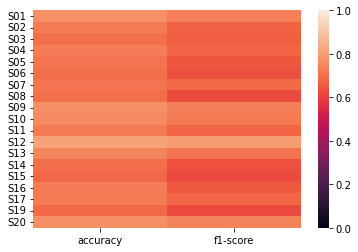

     class0 f1-score  class1 f1-score
S01         0.853755         0.463768
S02         0.828358         0.323529
S03         0.805861         0.329114
S04         0.830565         0.301370
S05         0.822222         0.225806
S06         0.814035         0.184615
S07         0.804428         0.417582
S08         0.812081         0.222222
S09         0.851351         0.450000
S10         0.847458         0.444444
S11         0.829630         0.281250
S12         0.875472         0.620690
S13         0.839858         0.415584
S14         0.809689         0.246575
S15         0.801370         0.216216
S16         0.834437         0.218750
S17         0.824427         0.342857
S19         0.801370         0.236842
S20         0.848921         0.487805


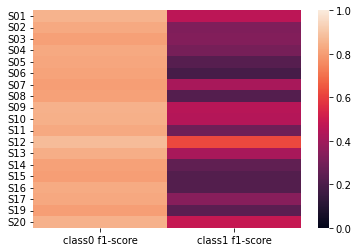

In [17]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [18]:
# pickle.dump(participants_dictionary, open(f"{saved_dir}/participant_dictionary-LSTM_EEGNet.pkl","wb"))